In [1]:
#Paquetes:

import os
import numpy as np
from PIL import Image #Se importa con pip install pillow, sirve para manejar imágenes
import matplotlib.pyplot as plt
import cv2 #una mehor libreŕia para manejar imágenes llamada "opencv"
from scipy.special import j1  #Para la función Jinc
import unicodedata


# Intento Miguel

4.6.0
Tamaño original: (480, 480, 3)


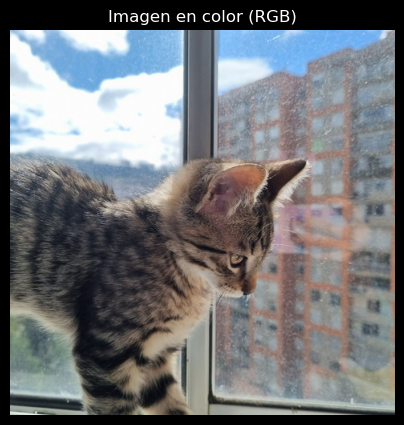

In [2]:
print(cv2.__version__)  

# Ruta de la imagen
base_dir = "talleres/taller1"   # <- ajusta si no estás en raíz del repo
data_path = "/home/miguel-perdomo/fourier-optics/talleres/taller1/dat/Imagen_prueba.jpeg" #Esta ruta se cambia según la ubicación exacta
img_color = cv2.imread(data_path, cv2.IMREAD_COLOR)

if img_color is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {data_path}")
else:
    print("Tamaño original:", img_color.shape)  # (alto, ancho, canales)

# Convertir de BGR -> RGB (para que se vea bien en Matplotlib)
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)


# Mostrar en el notebook
plt.figure(figsize=(5,5))
plt.imshow(img_rgb)
plt.title("Imagen en color (RGB)")
plt.axis("off")
plt.show()


Convertir la imágen en escala de grises 

tamaño original: (480, 480)
Imagen en gris guardada en: /home/miguel-perdomo/fourier-optics/talleres/taller1/results/Imagen_prueba_gray.png


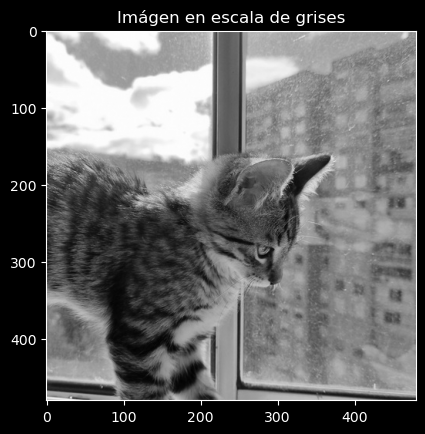

In [3]:
# Convertir a escala de grises
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
print("tamaño original:", img_gray.shape)

# Definir la ruta para guardarla
results_path = "/home/miguel-perdomo/fourier-optics/talleres/taller1/results" #De nuevo, esto se cambia dependiendo el local

# Guardar
gray_path = os.path.join(results_path, "Imagen_prueba_gray.png")
cv2.imwrite(gray_path, img_gray)

print(f"Imagen en gris guardada en: {gray_path}")
plt.Figure(figsize=(5,5))
plt.imshow(img_gray, cmap="gray")
plt.title("Imágen en escala de grises")
plt.show()

## 🎯 Filtro cuadrado en el dominio de Fourier y condición de Nyquist–Shannon

En la práctica de reconstrucción de imágenes muestreadas, se construye una **máscara cuadrada** que conserva únicamente el **ló­bulo central del espectro de Fourier**. La idea es aplicar un **filtro pasa-bajo ideal** que retenga las bajas frecuencias (información esencial de la imagen) y descarte las altas frecuencias que se solapan debido al submuestreo creo que se llama aliasing.

### 1. Relación con el Teorema de Nyquist–Shannon

El **Teorema de Nyquist–Shannon** establece que:

$$
f_s \geq 2 f_\text{max}
$$

donde:
- $ f_s $ es la **frecuencia de muestreo** (número de muestras por unidad de espacio),
- $ f_\text{max} $ es la **máxima frecuencia presente** en la señal.

Si esta condición no se cumple, ocurre **aliasing**: copias del espectro se solapan y la señal no puede reconstruirse sin distorsión.

En imágenes, si realizamos un **submuestreo cada $s$ píxeles**, la nueva frecuencia de muestreo espacial se reduce en un factor $s$. Para evitar aliasing, debemos limitar el espectro a una fracción \$tfrac{1}{s}$ del ancho original. (ESTO SE DEBERÍA EXPLICAR MEJOR EN EL OVERLEAF)

Por lo tanto, el tamaño del cuadrado central debe cumplir:

$$
W_x = \frac{N_x}{s}, 
\quad
W_y = \frac{N_y}{s}
$$

donde $(N_x, N_y)$ son las dimensiones del espectro.  
En la implementación, se toma esta proporción como `keep_frac = 1/s`.

---

### 2. Construcción de la máscara cuadrada

La función `square_mask` definida abajo, hace lo siguiente:

1. Inicializa una matriz de ceros (rechazo de todas las frecuencias).
2. Calcula el centro del espectro $(c_y, c_x)$.
3. Define un rango de índices que cubre aproximadamente \(\tfrac{1}{s}\) del total en cada dirección.
4. Asigna **1** dentro de ese cuadrado, manteniendo únicamente el **ló­bulo central**.

En notación:

$$
M(u,v) =
\begin{cases}
1 & \text{si } |u| \leq \tfrac{f_s}{2s}, \, |v| \leq \tfrac{f_s}{2s} \\
0 & \text{en otro caso}
\end{cases}
$$

donde $(u,v)$ son coordenadas en el dominio de frecuencia.

---

### 3. Intuición

- El cuadrado central **equivale a aplicar un pasa-bajo ideal** en ambas direcciones espaciales.  
- El tamaño del cuadrado depende directamente del factor de submuestreo \(s\).  
- Conservar solo esta fracción del espectro asegura que no haya **aliasing**, cumpliendo con la condición de Nyquist.

---

✅ **En resumen:**  
La máscara cuadrada implementa el teorema de Nyquist–Shannon en 2D: al submuestrear la imagen, reducimos la frecuencia de muestreo; para evitar aliasing, debemos filtrar en Fourier y conservar solo la porción central \(\tfrac{1}{s}\) del espectro.


## 🔄 Reconstrucción por Fourier con ventana cuadrada

La función `recon_fourier_square` implementa la reconstrucción de una imagen muestreada a partir de su transformada de Fourier, aplicando un **filtro cuadrado** centrado en la DC (frecuencia cero). El objetivo es retener únicamente el **ló­bulo central del espectro** y así evitar aliasing.

### 1. Entrada y parámetros

- `img_gray`: imagen muestreada en escala de grises (ndarray 2D).  
- `s`: factor de submuestreo (ej. 3, 5, 7).  
- `show`: si es `True`, muestra un panel con la imagen de entrada, la FFT, la máscara y la reconstrucción.  
- `save_dir`: si se indica, guarda el resultado en disco.  
- `tag`: etiqueta opcional para el nombre del archivo de salida.  

### 2. Procedimiento paso a paso

1. **Normalización**  
   Se convierte la imagen a tipo float en \([0,1]\):

   $$
   u(x,y) = \frac{I(x,y)}{255}, \quad I(x,y) \in [0,255]
   $$

2. **Transformada de Fourier 2D (centrada)**  
   Se calcula la FFT 2D con `FT2(u)`, que devuelve la transformada compleja \(U(u,v)\) con la DC en el centro.

   $$
   U(u,v) = \mathcal{F}\{u(x,y)\}
   $$

3. **Máscara cuadrada**  
   Usando la regla de Nyquist–Shannon, al submuestrear cada $s$ píxeles, solo se puede conservar la fracción central \(\tfrac{1}{s}\) del espectro:

   $$
   M(u,v) =
   \begin{cases}
   1 & \text{si } |u| \leq \tfrac{f_s}{2s}, \, |v| \leq \tfrac{f_s}{2s} \\
   0 & \text{otro caso}
   \end{cases}
   $$

   En el código, esto se traduce como:

   ```python
   keep_frac = 1.0 / s
   M = square_mask(Uc.shape, keep_frac)


# MEJOR MUESTREO (estaba mal y no había espacio para el aliasing)

Imagen original: 480×480
[OK] Guardada imagen muestreada con comb (f=3) en /home/miguel-perdomo/fourier-optics/talleres/taller1/results/Imagen_comb_sampled_3.png
[OK] Guardada imagen muestreada con comb (f=5) en /home/miguel-perdomo/fourier-optics/talleres/taller1/results/Imagen_comb_sampled_5.png
[OK] Guardada imagen muestreada con comb (f=7) en /home/miguel-perdomo/fourier-optics/talleres/taller1/results/Imagen_comb_sampled_7.png


<Figure size 1200x800 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

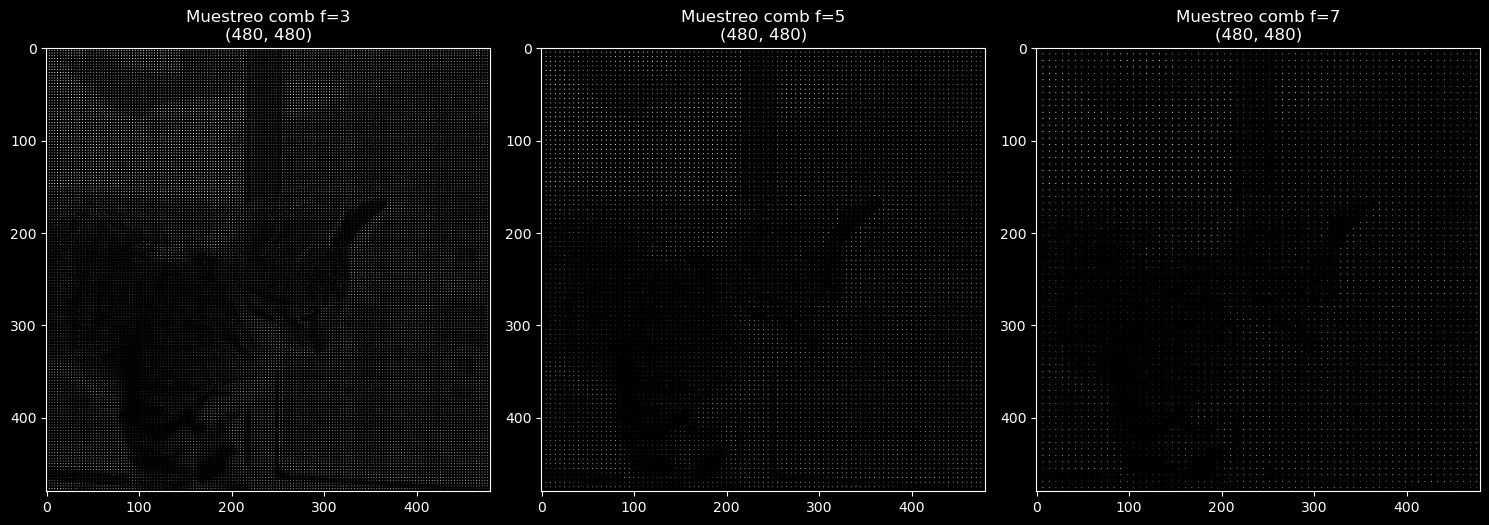

In [5]:
# === Ruta ===
results_path = "/home/miguel-perdomo/fourier-optics/talleres/taller1/results"

# === Imagen base ===
img_path = os.path.join(results_path, "Imagen_prueba_gray.png")
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img_gray is None:
    raise FileNotFoundError(f"No se encontró la imagen base: {img_path}")

H, W = img_gray.shape
print(f"Imagen original: {W}×{H}")

# === Factores de muestreo ===
factors = [3, 5, 7]
sampled_imgs = {}

for f in factors:
    # Creamos máscara "peine" (comb discreto)
    mask = np.zeros_like(img_gray, dtype=np.uint8)
    mask[::f, ::f] = 1  # deltas cada f píxeles

    # Muestreo = multiplicar imagen por el comb
    sampled = img_gray * mask
    sampled_imgs[f] = sampled

    # Guardar resultado
    out_path = os.path.join(results_path, f"Imagen_comb_sampled_{f}.png")
    cv2.imwrite(out_path, sampled)
    print(f"[OK] Guardada imagen muestreada con comb (f={f}) en {out_path}")

# === Mostrar resultados ===
plt.figure(figsize=(15, 6))
for i, f in enumerate(factors, 1):
    plt.subplot(1, 3, i)
    plt.imshow(sampled_imgs[f], cmap="gray")
    plt.title(f"Muestreo comb f={f}\n{sampled_imgs[f].shape}")
    plt.axis()
plt.tight_layout()
plt.show()

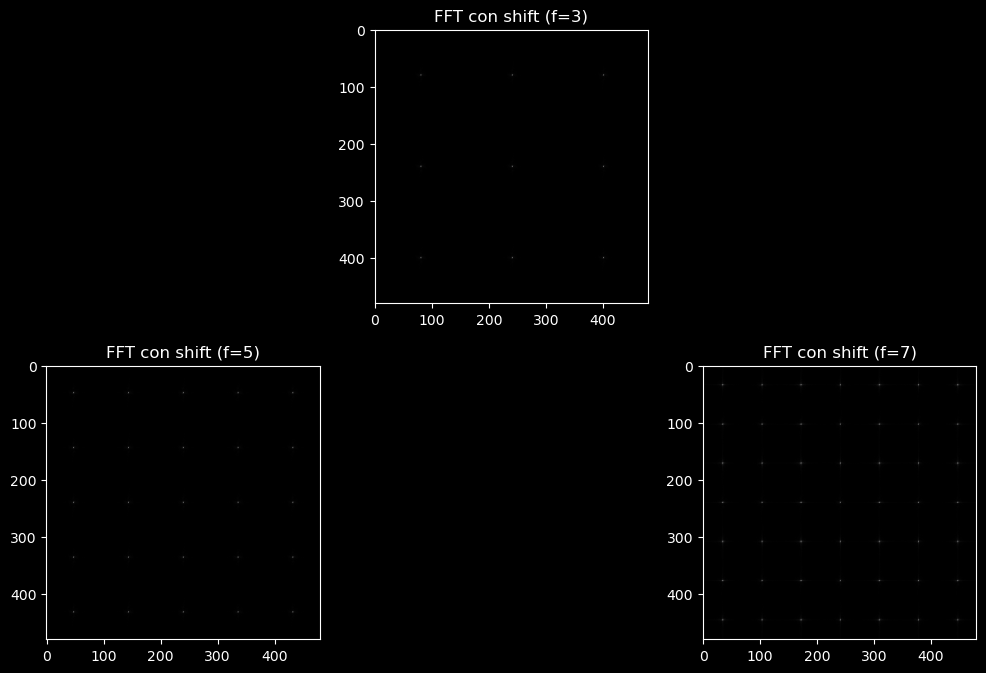

<Figure size 2000x500 with 0 Axes>

In [6]:
plt.figure(figsize=(12, 8))

for i, f in enumerate(factors, 1):
    # Cargar la imagen muestreada
    path = os.path.join(results_path, f"Imagen_comb_sampled_{f}.png")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen: {path}")

    arr = img.astype(np.float32)

    # FFT
    U = np.fft.fft2(arr)
    U_shift = np.fft.fftshift(U)

    plt.subplot(2, 3, 2*i)
    plt.imshow(np.abs(U_shift), cmap="gray")
    plt.title(f"FFT con shift (f={f})")
    plt.axis()

plt.figure(figsize=(20, 5))
plt.tight_layout()
plt.show()



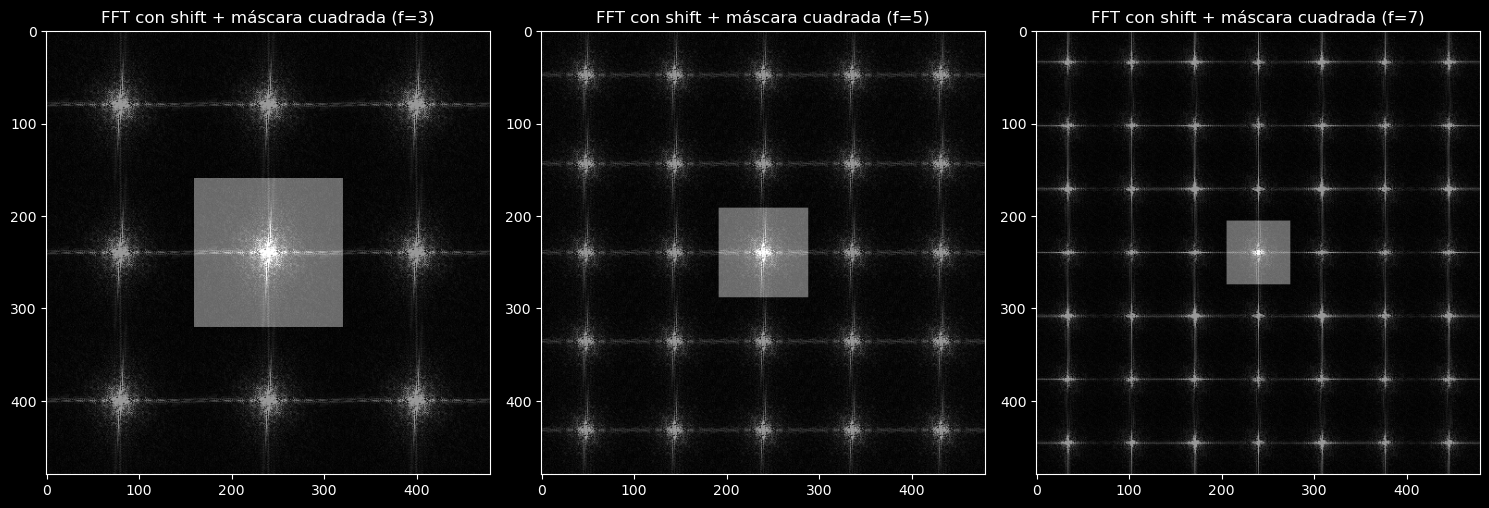

In [7]:
# --- Máscara cuadrada centrada que conserva una fracción del ancho/alto ---
def square_mask(shape, keep_frac):
    """
    shape = (Ny, Nx) de la imagen/espectro.
    keep_frac in (0,1]: fracción del ancho/alto que se conservará alrededor de DC.
    Devuelve máscara binaria con 1 en un cuadrado central y 0 fuera.
    """
    Ny, Nx = shape #Recordemos shape en escala de grises devuelve (alto, ancho) --> (480,480)
    wy = max(1, int(np.floor(keep_frac * Ny)))  # alto del cuadrado a conservar
    wx = max(1, int(np.floor(keep_frac * Nx)))  # ancho del cuadrado a conservar
    # forzamos a impar para centrar exactamente
    if wy % 2 == 0: wy += 1
    if wx % 2 == 0: wx += 1

    mask = np.zeros((Ny, Nx), dtype=np.float32)
    cy, cx = Ny // 2, Nx // 2  #Coordenadas del centro del espectro
    y0, y1 = cy - wy//2, cy + wy//2 + 1  #Calcular los limites del cuadrado
    x0, x1 = cx - wx//2, cx + wx//2 + 1
    mask[y0:y1, x0:x1] = 1.0 #tomar 1 solo para ese cuadrado
    return mask

plt.figure(figsize=(15, 5))

for i, f in enumerate(factors, 1):
    # Cargar la imagen muestreada
    path = os.path.join(results_path, f"Imagen_comb_sampled_{f}.png")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen: {path}")

    arr = img.astype(np.float32)

    # FFT con shift (DC al centro)
    U = np.fft.fft2(arr)
    U_shift = np.fft.fftshift(U)

    # Crear máscara cuadrada: Nyquist → conservar 1/f del espectro
    keep_frac = 1.0 / f
    M = square_mask(U_shift.shape, keep_frac)

    # Magnitud para graficar
    A = np.abs(U_shift)
    vmax = np.percentile(A, 99)  # recorte para que no se sature

    # Graficar espectro con máscara encima
    plt.subplot(1, 3, i)
    plt.imshow(A, cmap="gray", vmax=vmax)
    plt.imshow(M, cmap="gray", alpha=0.4)  # máscara superpuesta en color
    plt.title(f"FFT con shift + máscara cuadrada (f={f})")
    plt.axis()

plt.tight_layout()
plt.show()


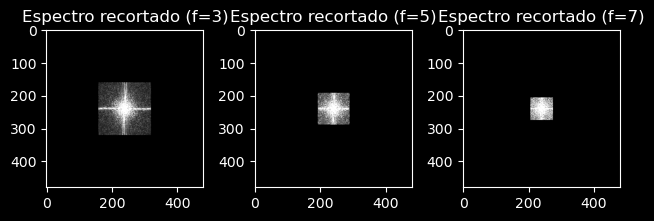

In [8]:
for i, f in enumerate(factors, 1):
    # Cargar la imagen muestreada
    path = os.path.join(results_path, f"Imagen_comb_sampled_{f}.png")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen: {path}")

    arr = img.astype(np.float32)

    # FFT con shift
    U = np.fft.fft2(arr)
    U_shift = np.fft.fftshift(U)

    # Crear máscara cuadrada
    keep_frac = 1.0 / f
    M = square_mask(U_shift.shape, keep_frac)

    # Aplicar máscara (recortar espectro)
    U_masked = U_shift * M

    # Magnitud del espectro recortado
    A = np.abs(U_masked)
    vmax = np.percentile(A, 99)

    # Graficar espectro recortado
    plt.subplot(1, 3, i)
    plt.imshow(A, cmap="gray", vmax=vmax)
    plt.title(f"Espectro recortado (f={f})")
    plt.axis()

plt.tight_layout()
plt.show()

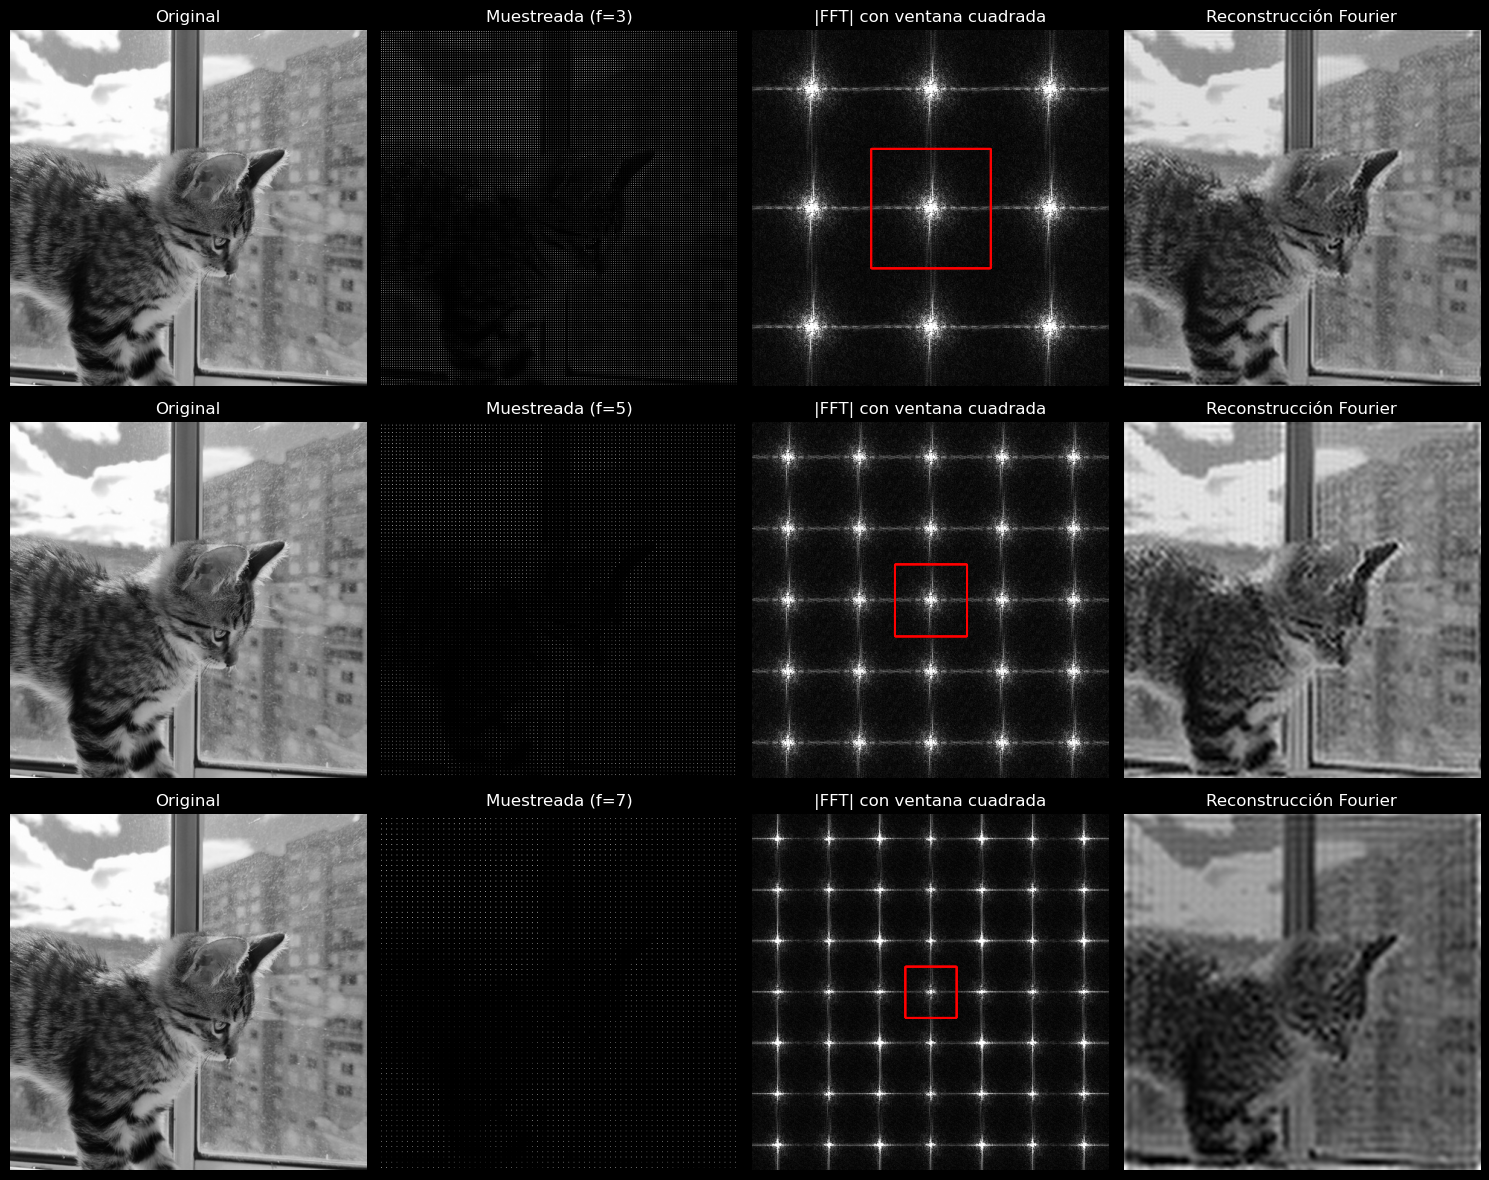

In [9]:
def FT2(u):
    """Transformada de Fourier 2D con DC centrada en el medio."""
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(u)))

def IFT2(U):
    """Transformada inversa de Fourier 2D con DC centrada en el medio."""
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(U)))

# --- Reconstrucción Fourier con ventana cuadrada ---
def recon_fourier_square(img_gray, s):
    u = img_gray.astype(np.float32)
    if u.max() > 1.0:
        u /= 255.0

    # FFT centrada
    Uc = FT2(u)

    # Máscara cuadrada
    keep_frac = 1.0 / float(s)
    M = square_mask(Uc.shape, keep_frac=keep_frac)

    # Espectro filtrado
    Uc_filt = Uc * M

    # Reconstrucción
    u_rec = IFT2(Uc_filt).real
    u_rec = np.clip(u_rec, 0.0, 1.0)

    return u, Uc, M, u_rec

# === Panel 3x3 ===
plt.figure(figsize=(15, 12))

for i, f in enumerate(factors, 1):
    u, Uc, M, u_rec = recon_fourier_square(sampled_imgs[f], f)
    img_orig = img_gray.astype(np.float32) / 255.0

    row = (i-1)*4

    # 1) Original
    plt.subplot(3, 4, row+1)
    plt.imshow(img_orig, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # 2) Imagen muestreada
    plt.subplot(3, 4, row+2)
    plt.imshow(u, cmap="gray")
    plt.title(f"Muestreada (f={f})")
    plt.axis("off")

    # 3) Espectro con cuadro superpuesto
    A = np.abs(Uc)
    vmax = np.percentile(A, 99)
    plt.subplot(3, 4, row+3)
    plt.imshow(A, cmap="gray", vmax=vmax)
    plt.contour(M, colors="red", linewidths=1)
    plt.title("|FFT| con ventana cuadrada")
    plt.axis("off")

    # 4) Imagen reconstruida
    plt.subplot(3, 4, row+4)
    plt.imshow(u_rec, cmap="gray")
    plt.title("Reconstrucción Fourier")
    plt.axis("off")

plt.tight_layout()
plt.show()


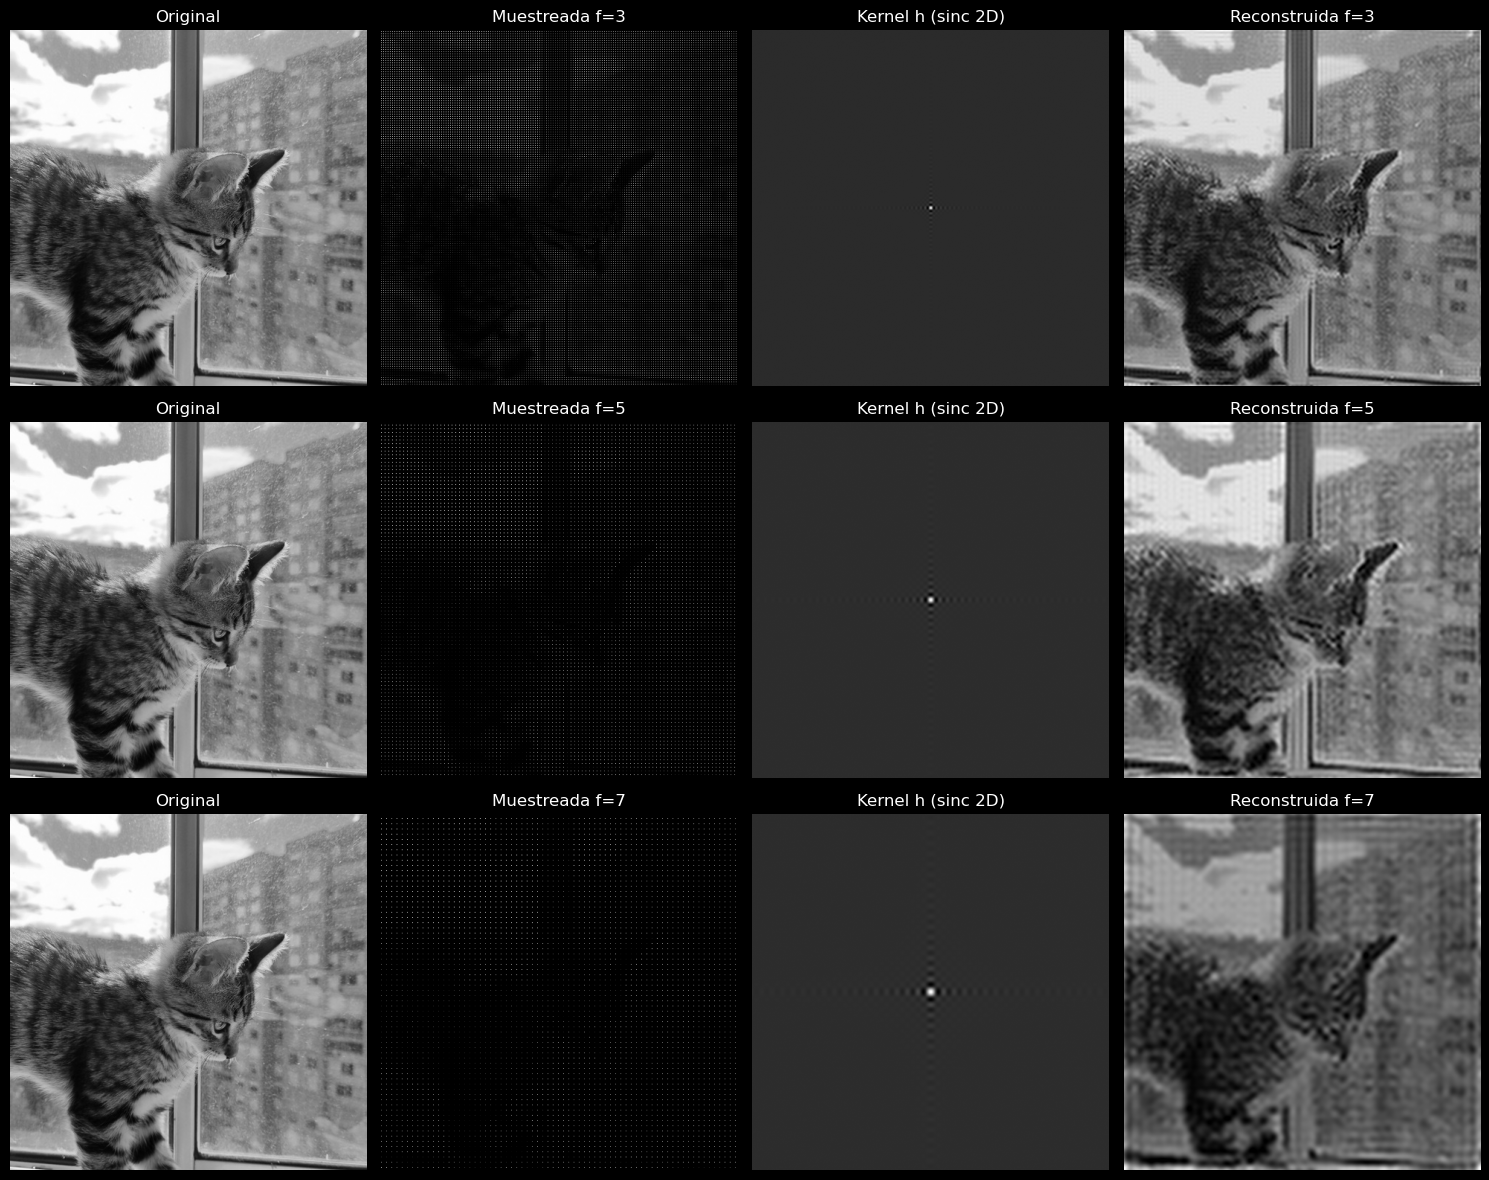

In [10]:
# === Kernel sinc 2D FULL ===
def sinc_kernel_square_full(Ny, Nx, s):
    k = 1.0 / float(s)
    m = np.arange(Ny) - Ny//2
    n = np.arange(Nx) - Nx//2
    hm = np.sinc(k*m)
    hn = np.sinc(k*n)
    h  = (k**2) * np.outer(hm, hn)
    h /= h.sum()
    return h.astype(np.float32)

# === Convolución vía FFT (rápido) ===
def convolve_via_fft(u, h):
    Ny, Nx = u.shape
    Hy, Hx = h.shape
    if (Hy, Hx) != (Ny, Nx):
        Hpad = np.zeros((Ny, Nx), dtype=np.float32)
        cy, cx = Ny//2, Nx//2
        hy, hx = Hy//2, Hx//2
        y0, y1 = cy-hy, cy+hy+1
        x0, x1 = cx-hx, cx+hx+1
        Hpad[y0:y1, x0:x1] = h
        h = Hpad
    U  = FT2(u)
    H  = FT2(h)
    Y  = U * H
    y  = IFT2(Y).real
    return np.clip(y, 0.0, 1.0).astype(np.float32)

# === Panel 12 imágenes ===
plt.figure(figsize=(15, 12))

for i, s in enumerate(factors, 1):
    # Imagen muestreada
    path = os.path.join(results_path, f"Imagen_comb_sampled_{s}.png")
    img_s = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_s is None:
        raise FileNotFoundError(path)
    u_s = img_s.astype(np.float32) / 255.0

    # Imagen original (antes de muestreo)
    img_path = os.path.join(results_path, "Imagen_prueba_gray.png")
    img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0

    # Kernel sinc 2D
    h = sinc_kernel_square_full(*u_s.shape, s=s)

    # Reconstrucción
    u_rec = convolve_via_fft(u_s, h)

    # --- Mostrar ---
    row = (i-1)*4
    plt.subplot(3,4,row+1); plt.imshow(img_orig, cmap="gray")
    plt.title(f"Original"); plt.axis("off")

    plt.subplot(3,4,row+2); plt.imshow(u_s, cmap="gray")
    plt.title(f"Muestreada f={s}"); plt.axis("off")

    plt.subplot(3,4,row+3); plt.imshow(h, cmap="gray")
    plt.title(f"Kernel h (sinc 2D)"); plt.axis("off")

    plt.subplot(3,4,row+4); plt.imshow(u_rec, cmap="gray")
    plt.title(f"Reconstruida f={s}"); plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
def circular_mask(shape, keep_frac):
    """
    Máscara circular centrada en DC.
    - shape: (Ny, Nx)
    - keep_frac: fracción del radio máximo a conservar (~1/s).
    """
    Ny, Nx = shape
    Y, X = np.ogrid[:Ny, :Nx]
    cy, cx = Ny // 2, Nx // 2
    r = np.sqrt((X - cx)**2 + (Y - cy)**2)
    rmax = min(Ny, Nx) / 2
    R = keep_frac * rmax
    mask = (r <= R).astype(np.float32)
    return mask


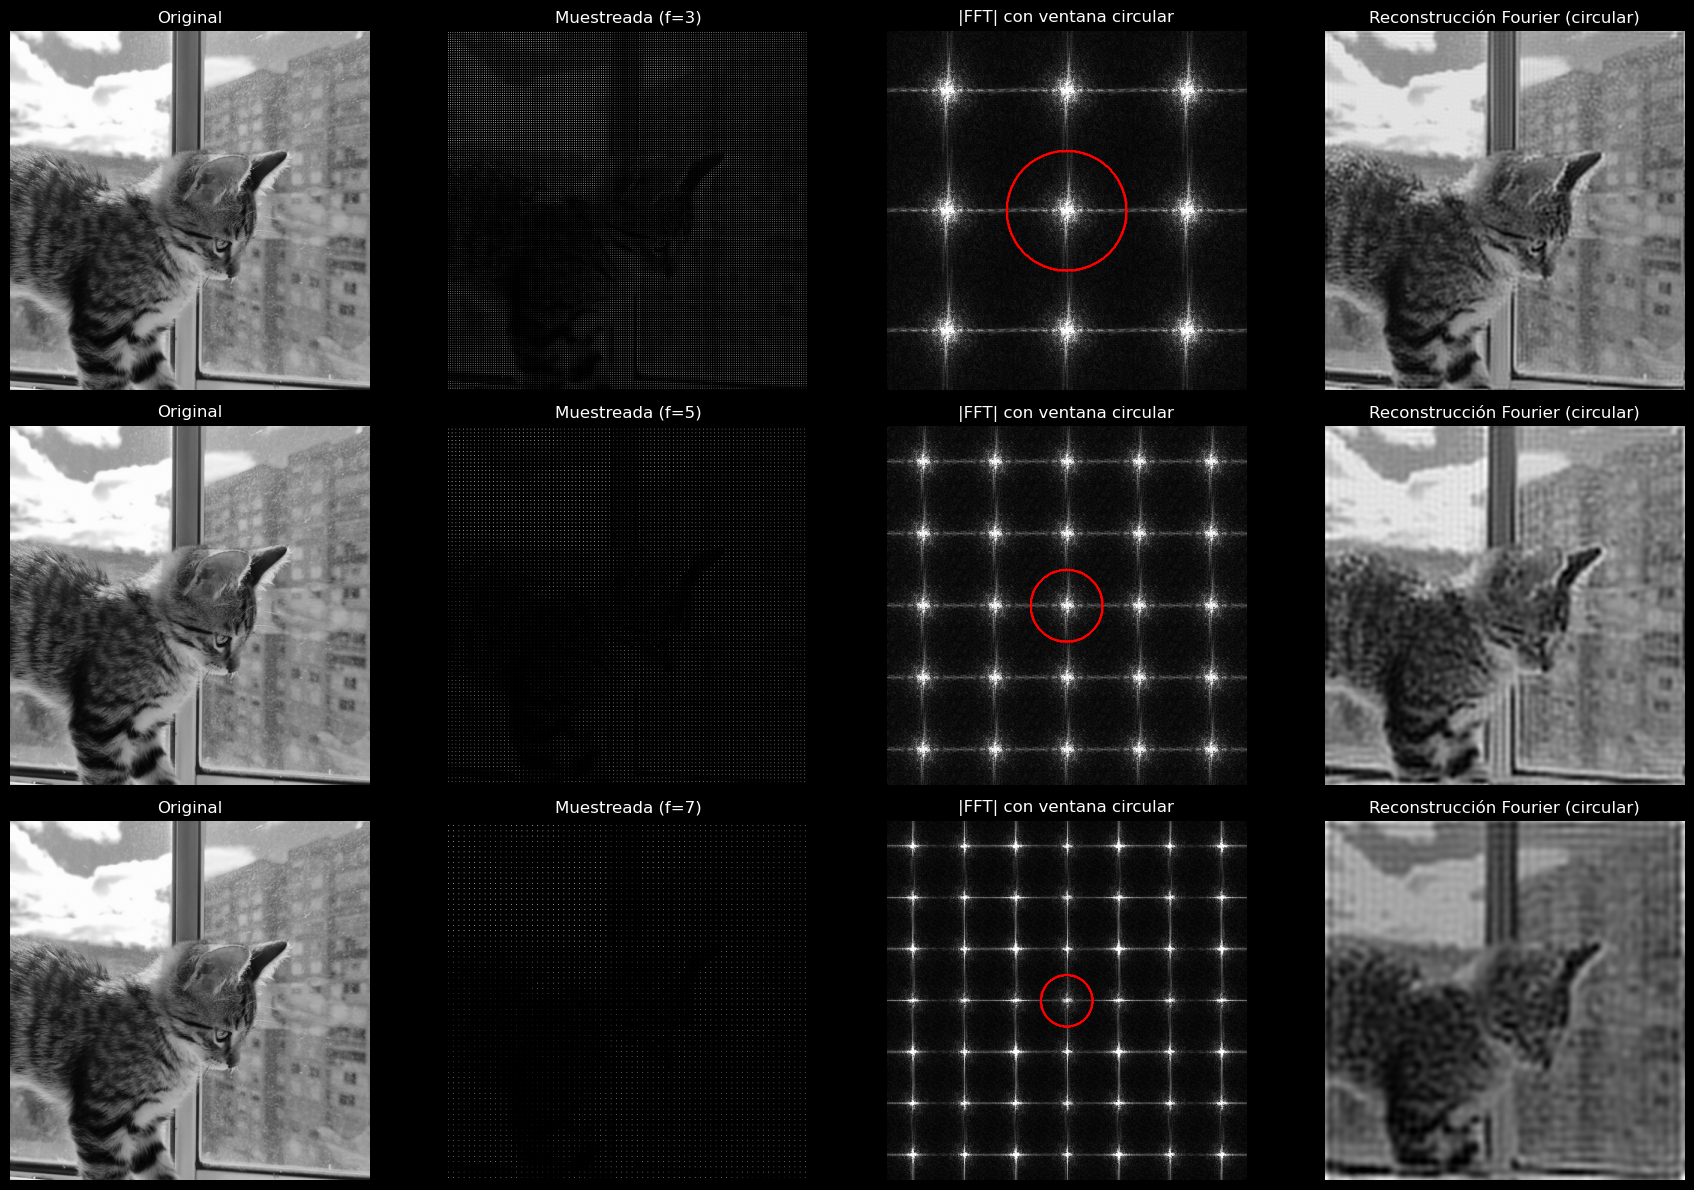

In [12]:
# === Paso 2 (versión circular): Reconstrucción Fourier con máscara circular ===

plt.figure(figsize=(18, 12))

for i, f in enumerate(factors, 1):
    # Imagen muestreada
    path = os.path.join(results_path, f"Imagen_comb_sampled_{f}.png")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró la imagen: {path}")

    u = img.astype(np.float32) / 255.0
    img_orig = img_gray.astype(np.float32) / 255.0

    # FFT centrada
    Uc = FT2(u)

    # Máscara circular (Nyquist -> conservar 1/s del espectro)
    keep_frac = 1.0 / float(f)
    M = circular_mask(Uc.shape, keep_frac=keep_frac)

    # Espectro filtrado y reconstrucción
    Uc_filt = Uc * M
    u_rec = IFT2(Uc_filt).real
    u_rec = np.clip(u_rec, 0.0, 1.0)

    row = (i-1)*4

    # 1) Original
    plt.subplot(3, 4, row+1)
    plt.imshow(img_orig, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # 2) Imagen muestreada
    plt.subplot(3, 4, row+2)
    plt.imshow(u, cmap="gray")
    plt.title(f"Muestreada (f={f})")
    plt.axis("off")

    # 3) Espectro con máscara circular
    A = np.abs(Uc)
    vmax = np.percentile(A, 99)
    plt.subplot(3, 4, row+3)
    plt.imshow(A, cmap="gray", vmax=vmax)
    plt.contour(M, colors="red", linewidths=1)
    plt.title("|FFT| con ventana circular")
    plt.axis("off")

    # 4) Reconstrucción Fourier
    plt.subplot(3, 4, row+4)
    plt.imshow(u_rec, cmap="gray")
    plt.title("Reconstrucción Fourier (circular)")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
# ========= Aproximación de J1(x) SOLO NUMPY =========
def j1_np(x, terms=30, x_switch=8.0):
    """
    J1(x): serie de Taylor para x<x_switch y asintótica para x>=x_switch.
    """
    x = np.asarray(x, dtype=np.float64)
    out = np.empty_like(x)

    # Región 'pequeña': serie
    small = x < x_switch
    xs = x[small]
    if xs.size:
        # J1(x) = sum_{m=0}^\infty (-1)^m / [m!(m+1)!] * (x/2)^{2m+1}
        res = np.zeros_like(xs)
        halfx = xs/2.0
        for m in range(terms):
            coef = (-1.0)**m / (np.math.factorial(m)*np.math.factorial(m+1))
            res += coef * (halfx**(2*m+1))
        out[small] = res

    # Región 'grande': asintótica de Debye (primeros dos términos)
    large = ~small
    xl = x[large]
    if xl.size:
        phi = xl - 3.0*np.pi/4.0
        out[large] = np.sqrt(2.0/(np.pi*xl)) * (np.cos(phi) - (3.0/(8.0*xl))*np.sin(phi))

    return out

# ========= Kernel jinc 2D correcto (sin normalizar r) =========
def jinc_kernel_np(Ny, Nx, s):
    """
    h[m,n] = 2R * J1(2πR r_pix) / r_pix, con R = 1/(2s) (ciclos/píxel).
    r_pix en píxeles (NO normalizado). Centro: h(0)=2πR^2.
    """
    R = 1.0/(2.0*float(s))  # cic/pix
    Y, X = np.mgrid[:Ny, :Nx]
    cy, cx = Ny//2, Nx//2
    r = np.sqrt((X - cx)**2 + (Y - cy)**2).astype(np.float64)

    z = 2.0*np.pi*R*r
    h = np.zeros_like(r, dtype=np.float64)
    mask = r > 0
    h[mask] = 2.0*R * j1_np(z[mask]) / r[mask]
    # valor límite en el centro: h(0)=lim_{r->0} 2R*J1(2πR r)/r = 2π R^2
    h[~mask] = 2.0*np.pi*(R**2)

    # Normalizar para que la ganancia DC sea 1
    h = h.astype(np.float32)
    h /= (h.sum() + 1e-12)
    return h


/tmp/ipykernel_17607/2379296815.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef = (-1.0)**m / (np.math.factorial(m)*np.math.factorial(m+1))


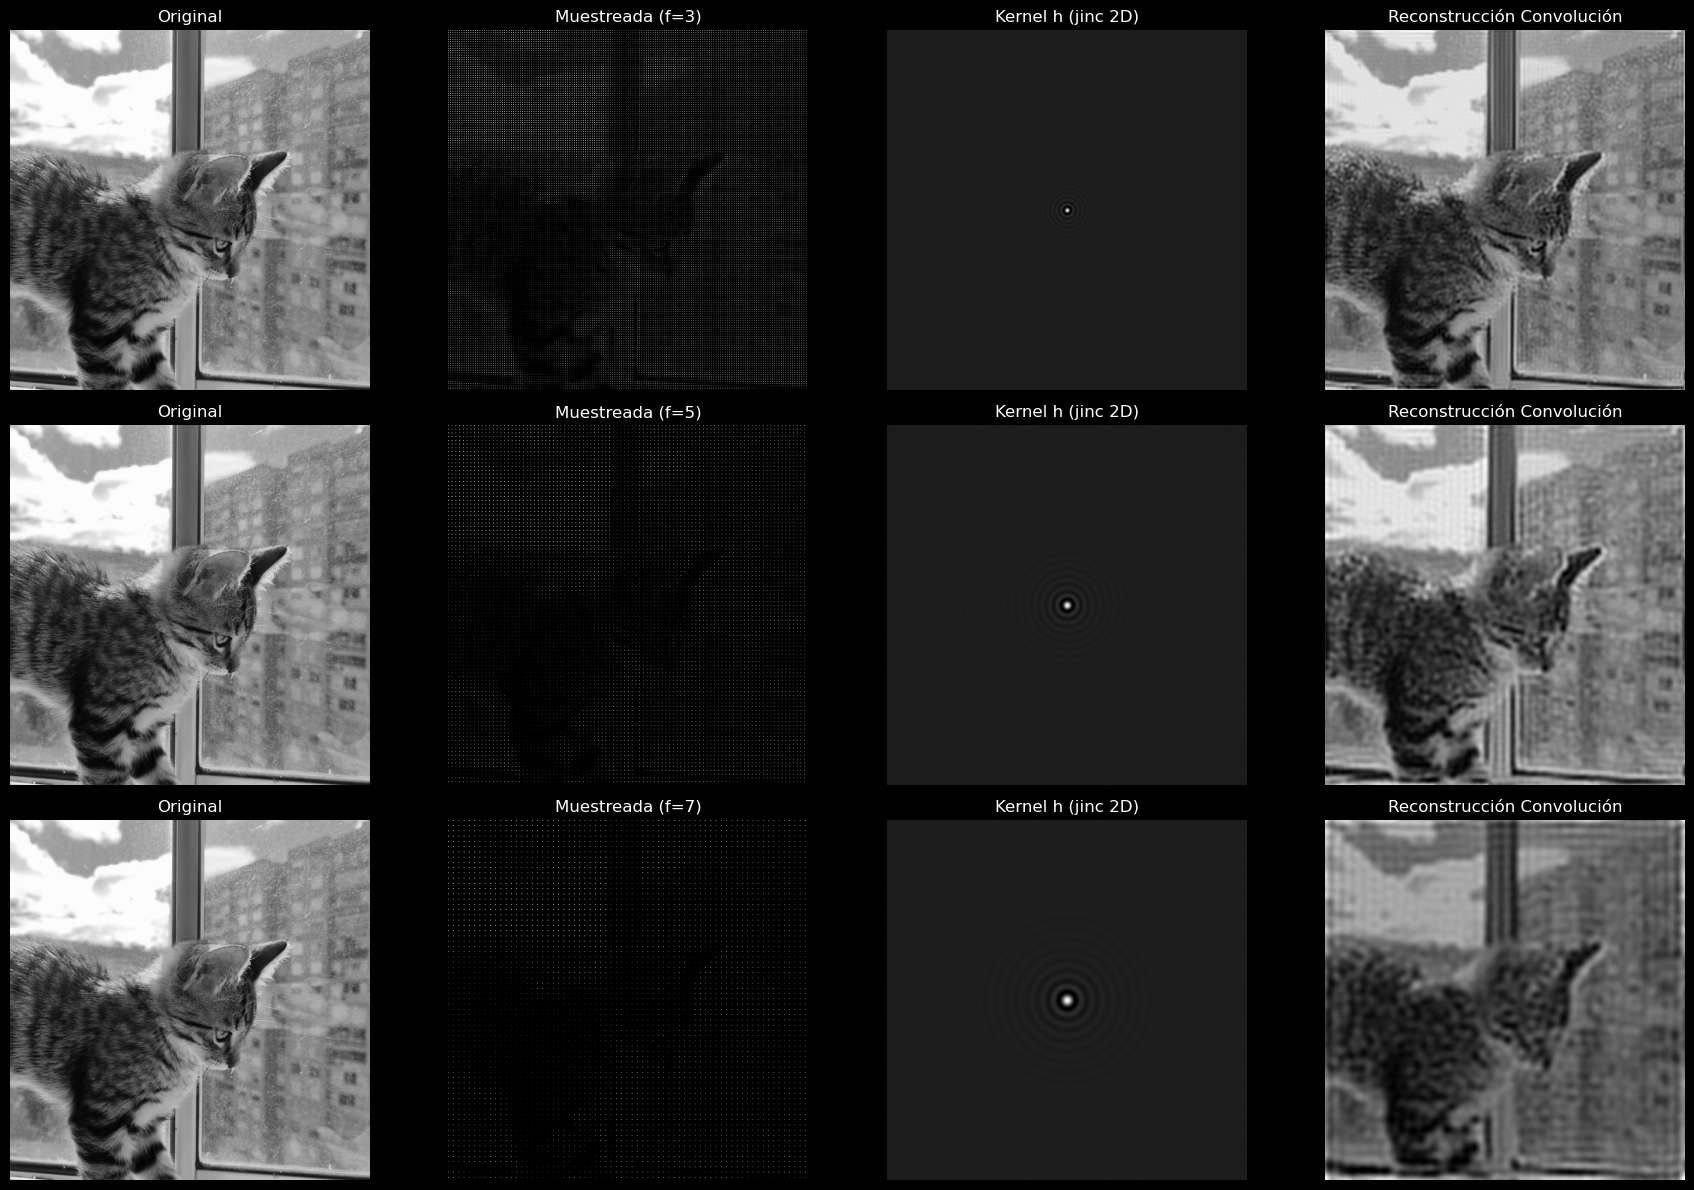

In [14]:
plt.figure(figsize=(18, 12))
img_orig = img_gray.astype(np.float32)/255.0

for i, f in enumerate(factors, 1):
    u_s = sampled_imgs[f].astype(np.float32)/255.0

    # Kernel jinc 2D (tamaño de la imagen)
    h = jinc_kernel_np(*u_s.shape, s=f)

    # Reconstrucción por convolución (vía FFT)
    u_rec = convolve_via_fft(u_s, h)

    row = (i-1)*4
    # 1) Original
    plt.subplot(3,4,row+1); plt.imshow(img_orig, cmap="gray"); plt.title("Original"); plt.axis("off")
    # 2) Muestreada
    plt.subplot(3,4,row+2); plt.imshow(u_s, cmap="gray"); plt.title(f"Muestreada (f={f})"); plt.axis("off")
    # 3) Kernel jinc (mostrar con contraste)
    plt.subplot(3,4,row+3)
    h_show = h / (h.max() + 1e-12)
    plt.imshow(h_show, cmap="gray"); plt.title("Kernel h (jinc 2D)"); plt.axis("off")
    # 4) Reconstruida
    plt.subplot(3,4,row+4); plt.imshow(u_rec, cmap="gray"); plt.title("Reconstrucción Convolución"); plt.axis("off")

plt.tight_layout(); plt.show()